<a href="https://colab.research.google.com/github/brucebra000/DS-Unit-2-Kaggle-Challenge/blob/master/U2S2A4_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [2]:
!pip install matplotlib==3.1.0

In [3]:
import matplotlib
print(matplotlib.__version__)

3.1.0


In [4]:
!pip install scikit-plot

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from google.colab import files

In [0]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [8]:
print(train.shape)
train.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
#Validation set
train, val = train_test_split(train, stratify = train['status_group'], random_state = 1)
train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [0]:
#Wrangling data
def wrangle(x):
  x = x.copy()

  x['latitude'] = x['latitude'].replace(-2e-08, 0)

  zero_cols = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  for col in zero_cols:
    x[col] = x[col].replace(0, np.nan)
    x[col+'_MISSING'] = x[col].isnull()
  
  duplicates = ['quantity_group', 'payment_type']
  x = x.drop(columns = duplicates)

  unusable = ['recorded_by', 'id']
  x = x.drop(columns = unusable)

  x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format = True)
  x['year_recorded'] = x['date_recorded'].dt.year
  x['month_recorded'] = x['date_recorded'].dt.month
  x['day_recorded'] = x['date_recorded'].dt.day

  x['years'] = x['year_recorded'] - x['construction_year']
  x['years_MISSING'] = x['years'].isnull()

  return x

In [11]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

train.shape, val.shape, test.shape

((44550, 47), (14850, 47), (14358, 46))

In [0]:
#Feature sets and targets
target = 'status_group'
train_features = train.drop(columns = [target])
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()
cardinality = train_features.select_dtypes(exclude = 'number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [13]:
#Pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True, cols = ['basin']),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs = -1)
)

pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8015488215488216


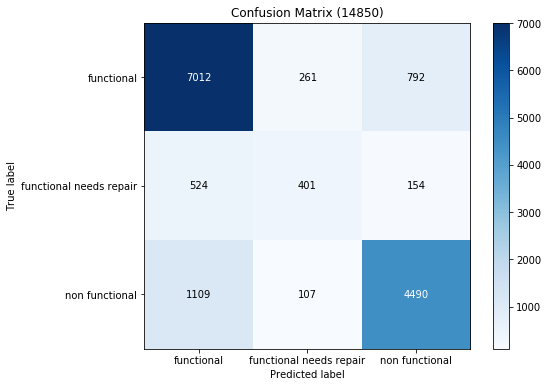

In [14]:
#Confusion Matrix
skplt.metrics.plot_confusion_matrix(
    y_val,
    y_pred,
    figsize = (8, 6),
    title = f'Confusion Matrix ({len(y_val)})',
    normalize = False
);

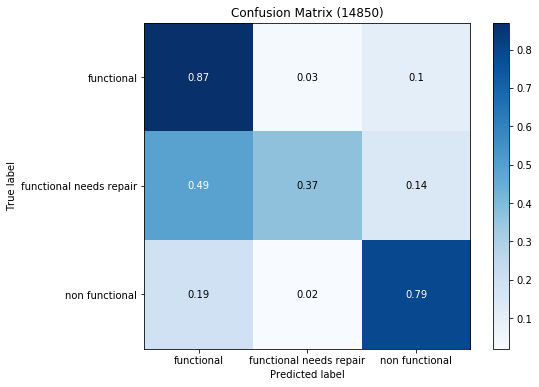

In [15]:
#Confusion Matrix (Normalized))
skplt.metrics.plot_confusion_matrix(
    y_val,
    y_pred,
    figsize = (8, 6),
    title = f'Confusion Matrix ({len(y_val)})',
    normalize = True
);